In [2]:
# import libraries
import boto3
import json
import sagemaker
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sagemaker.amazon.amazon_estimator import get_image_uri

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-deepar'
my_region = boto3.session.Session().region_name # set the region of the instance

image_uri = get_image_uri(boto3.Session().region_name, "forecasting-deepar")

print("Success - the MySageMakerInstance is in the " + my_region + " region.")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Success - the MySageMakerInstance is in the ap-northeast-2 region.


In [5]:
bucket_name = 'YOUR_BUCKET'
s3 = boto3.resource('s3')

In [6]:
from botocore.exceptions import ClientError

def download_from_s3(url):
    """ex: url = s3://sagemakerbucketname/data/validation.tfrecords"""
    url_parts = url.split("/") 
    bucket_name = url_parts[2]
    key = os.path.join(*url_parts[3:])
    filename = url_parts[-1]
    if not os.path.exists(filename):
        try:
            print('Downloading {} to {}'.format(url, filename))
            s3.Bucket(bucket_name).download_file(key, filename)
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                print('The object {} does not exist in bucket {}'.format(
                    key, bucket_name))
            else:
                raise

In [ ]:
# download all files
files = ['sale', 'summary', 'grade', 'genre', 'director', 'company', 'codes']

for file in files:
    download_from_s3(f'YOUR_BUCKET_PATH/{file}.csv')


In [21]:
sales = pd.read_csv('movie_sale.csv')
summary = pd.read_csv('movie_summary.csv')
grade = pd.read_csv('movie_grade.csv')
genre = pd.read_csv('movie_genre.csv')
codes = pd.read_csv('movie_codes.csv')
director = pd.read_csv('movie_director.csv')
company = pd.read_csv('movie_company.csv')

# Objective 
### Provide forecast on sales based on genre & audiCnt

## EDA

In [22]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3640 non-null   int64  
 1   rank           3640 non-null   int64  
 2   rankInten      3640 non-null   int64  
 3   rankOldAndNew  3640 non-null   object 
 4   movieCd        3640 non-null   int64  
 5   movieNm        3640 non-null   object 
 6   openDt         3640 non-null   object 
 7   salesAmt       3640 non-null   int64  
 8   salesShare     3640 non-null   float64
 9   salesInten     3640 non-null   int64  
 10  salesChange    3640 non-null   float64
 11  salesAcc       3640 non-null   int64  
 12  audiCnt        3640 non-null   int64  
 13  audiInten      3640 non-null   int64  
 14  audiChange     3640 non-null   float64
 15  audiAcc        3640 non-null   int64  
 16  scrnCnt        3640 non-null   int64  
 17  showCnt        3640 non-null   int64  
dtypes: float

In [23]:
sales.describe()

,date,rank,rankInten,movieCd,salesAmt,salesShare,salesInten,salesChange,salesAcc,audiCnt,audiInten,audiChange,audiAcc,scrnCnt,showCnt
count,3.640000e+03,3640.000000,3640.000000,3.640000e+03,3.640000e+03,3640.000000,3.640000e+03,3640.000000,3.640000e+03,3640.000000,3640.000000,3640.000000,3.640000e+03,3640.000000,3640.000000
mean,2.022473e+07,5.499176,0.782418,2.021575e+07,3.501576e+08,9.479643,2.793908e+06,445.980275,1.593931e+10,33378.625549,280.630495,433.992005,1.520834e+06,525.109615,1518.315934
std,4.621375e+03,2.871528,5.346670,2.960361e+04,8.034379e+08,14.530367,5.261001e+08,7381.147769,2.740807e+10,73642.933935,48753.670969,5531.915211,2.543370e+06,476.061552,2005.921508
min,2.022053e+07,1.000000,-7.000000,1.952800e+07,2.248000e+06,0.000000,-6.702835e+09,-96.800000,4.750000e+06,270.000000,-657333.000000,-96.500000,6.240000e+02,1.000000,1.000000
25%,2.022083e+07,3.000000,0.000000,2.020965e+07,2.761592e+07,1.100000,-2.975781e+07,-22.725000,5.505436e+08,2857.000000,-2808.750000,-23.125000,5.281225e+04,168.000000,240.000000
50%,2.022113e+07,5.500000,0.000000,2.022506e+07,8.221717e+07,3.200000,5.810785e+05,1.500000,3.694217e+09,8046.000000,80.500000,1.650000,3.647375e+05,407.000000,660.000000
75%,2.023023e+07,8.000000,0.000000,2.022789e+07,3.034451e+08,10.000000,2.798410e+07,58.025000,1.856277e+10,29310.750000,2697.250000,54.300000,1.818417e+06,749.000000,1977.250000
max,2.023053e+07,10.000000,95.000000,2.023991e+07,1.015439e+10,86.000000,7.762594e+09,381426.800000,1.373266e+11,852525.000000,763018.000000,230444.400000,1.279793e+07,2809.000000,12812.000000


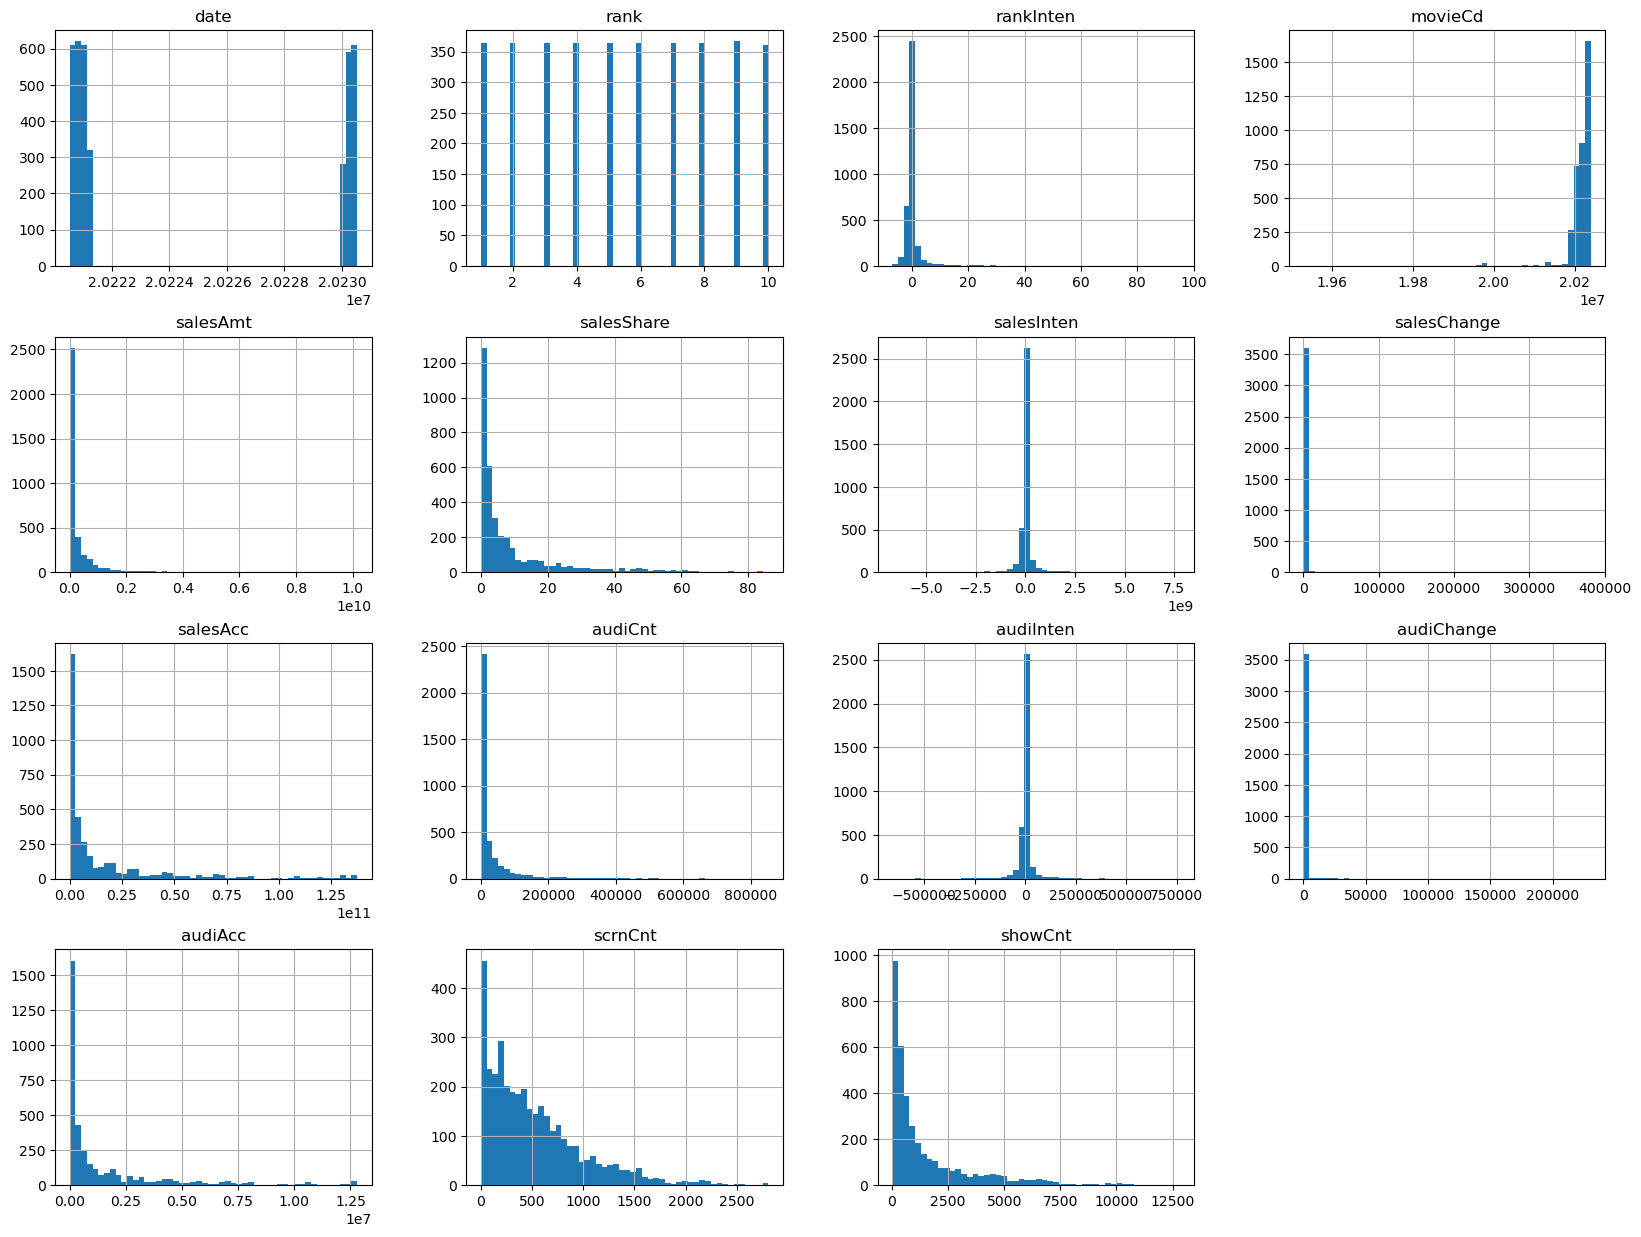

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
sales.hist(bins=50, figsize=(20,15))
plt.show()

In [36]:
# Select unskewed columns
sales_df = sales[['date','movieCd', 'movieNm', 'salesAmt', 'salesShare', 'scrnCnt', 'showCnt', 'audiCnt']]
sales_df

,date,movieCd,movieNm,salesAmt,salesShare,scrnCnt,showCnt,audiCnt
0,20220530,20204548,범죄도시2,2011949470,83.1,2357,12613,201418
1,20220530,20212855,닥터 스트레인지: 대혼돈의 멀티버스,203802130,8.4,695,2461,18972
2,20220530,20224634,그대가 조국,145421230,6.0,457,1075,14894
3,20220530,20224304,피는 물보다 진하다,7424400,0.3,71,117,1200
4,20220530,20217334,안녕하세요,7737900,0.3,208,289,998
...,...,...,...,...,...,...,...,...
3635,20230528,20231348,극장판 짱구는 못말려: 동물소환 닌자 배꼽수비대,212082259,2.8,445,628,20933
3636,20230528,19960041,아기공룡 둘리-얼음별 대모험,173174088,2.3,445,612,18312
3637,20230528,20231677,남은 인생 10년,145137100,1.9,201,375,13032
3638,20230528,20226270,스즈메의 문단속,128179167,1.7,315,394,12764


## Drop outliers


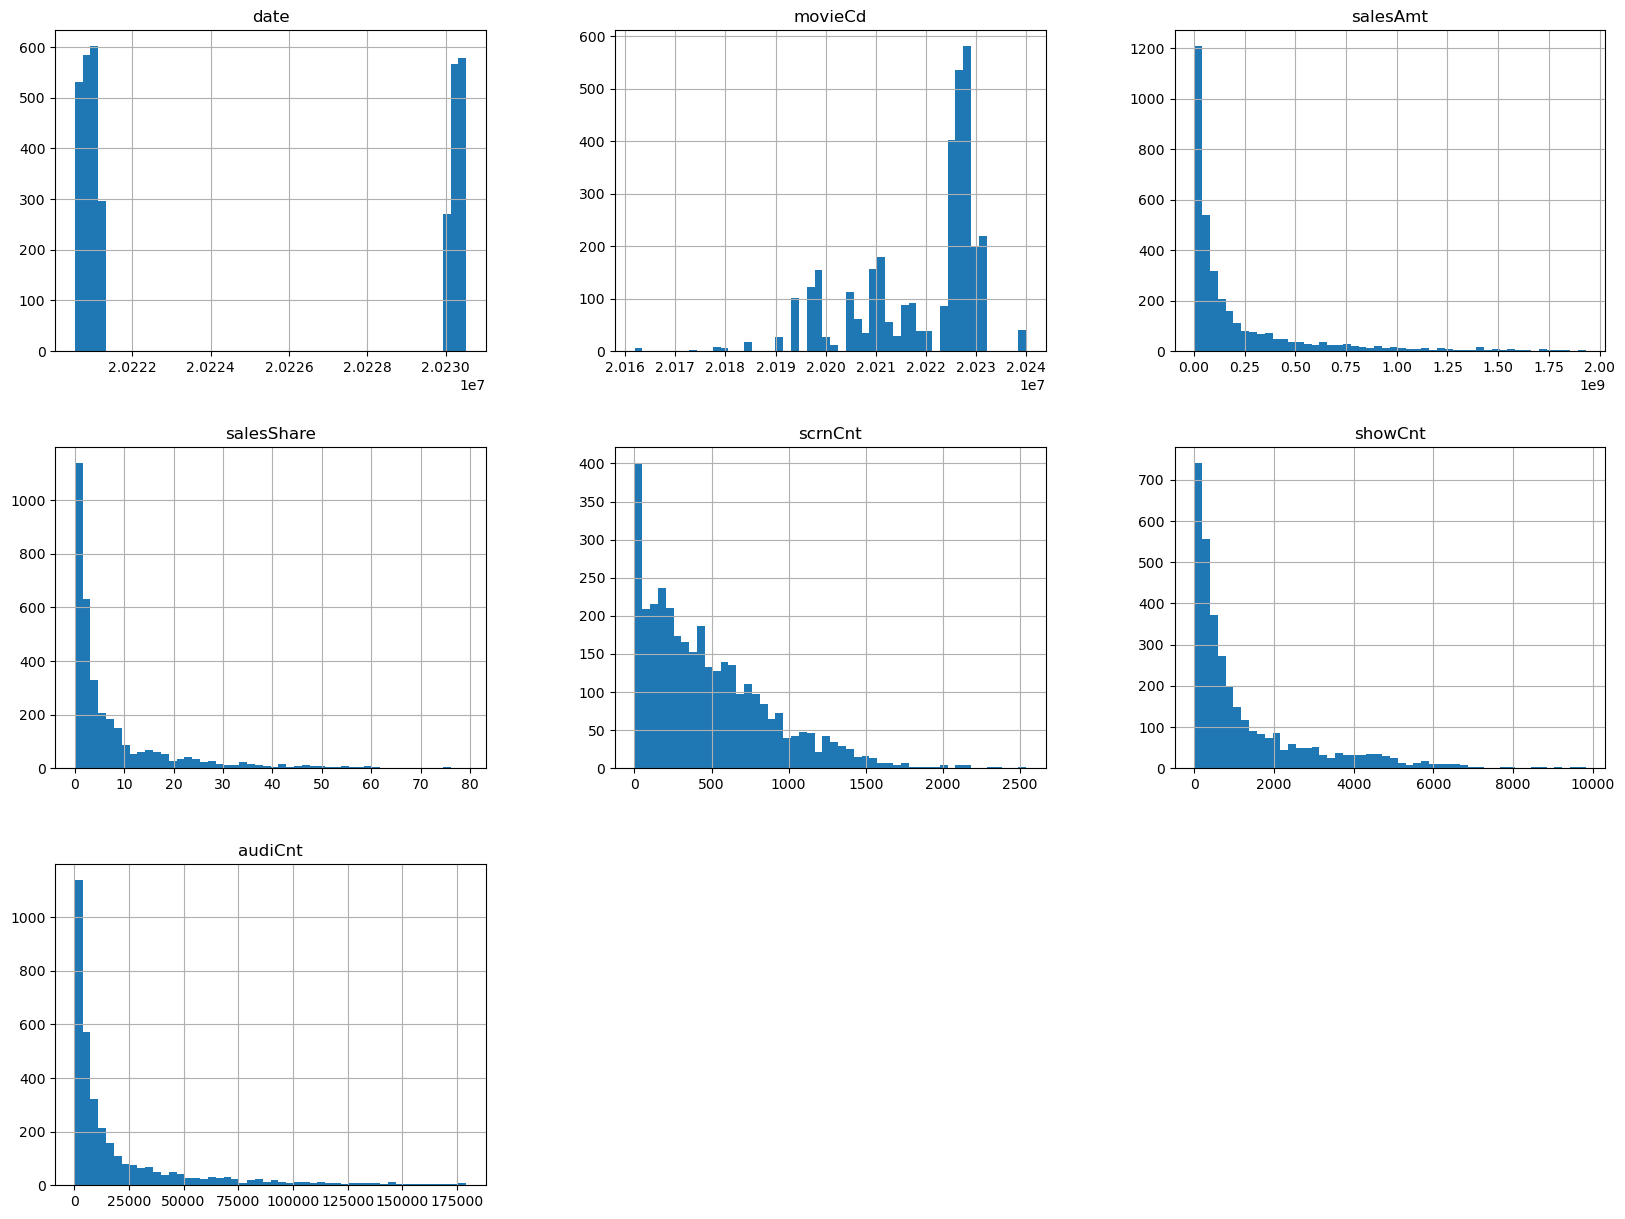

In [37]:
from scipy import stats
sales_df2 = sales_df[(np.abs(stats.zscore(sales_df[['audiCnt', 'salesAmt', 'movieCd']])) < 2).all(axis=1)]
sales_df2.hist(bins=50, figsize=(20,15))

plt.show()

## Join Genres and drop duplicates


In [38]:
def drop_duplicates_in_list(lst):
    return list(set(lst))

merged_df = pd.merge(sales_df2, genre, on='movieCd', how='inner')

grouped_df = merged_df.groupby('movieCd')['genres'].apply(list).reset_index(name='genres')
grouped_df['genres'] = grouped_df['genres'].apply(drop_duplicates_in_list)

final_df = pd.merge(sales_df2, grouped_df, on='movieCd', how='left')

final_df['genres'] = final_df['genres'].apply(lambda x: ', '.join(x))


## Stratified split


In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the rare genres with only one instance
genre_counts = final_df['genres'].value_counts()
rare_genres = genre_counts[genre_counts < 29].index

final_df['genres'] = final_df['genres'].replace(rare_genres, 'Other')

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(final_df, final_df["genres"]):
    strat_train_set = final_df.loc[train_index]
    strat_test_set = final_df.loc[test_index]

In [40]:
strat_test_set["genres"].value_counts() / len(strat_test_set)

애니메이션                0.198251
Other                0.126822
드라마                  0.119534
액션                   0.087464
코미디, 액션              0.037901
코미디                  0.032070
멜로/로맨스               0.032070
드라마, 액션              0.029155
공포(호러), 미스터리         0.026239
드라마, 코미디             0.024781
어드벤처, 애니메이션, 코미디     0.021866
범죄, 액션               0.020408
스릴러                  0.020408
어드벤처, 애니메이션, 액션      0.018950
드라마, 뮤지컬             0.018950
어드벤처, 판타지, 액션        0.018950
뮤지컬                  0.018950
멜로/로맨스, 미스터리         0.017493
다큐멘터리                0.017493
SF, 어드벤처, 스릴러, 액션    0.016035
기타                   0.014577
어드벤처, 액션             0.011662
다큐멘터리, 공연            0.011662
스릴러, 액션              0.011662
범죄, 스릴러              0.010204
SF, 어드벤처, 액션         0.010204
드라마, 멜로/로맨스, 판타지     0.008746
어드벤처, 드라마, 액션        0.008746
스릴러, 미스터리            0.008746
Name: genres, dtype: float64

In [41]:
corr_matrix = final_df.corr()
corr_matrix["salesAmt"].sort_values(ascending=False)

/tmp/ipykernel_11879/1179803201.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_df.corr()


salesAmt      1.000000
audiCnt       0.993099
showCnt       0.809929
salesShare    0.792085
scrnCnt       0.786616
date          0.008859
movieCd      -0.095757
Name: salesAmt, dtype: float64

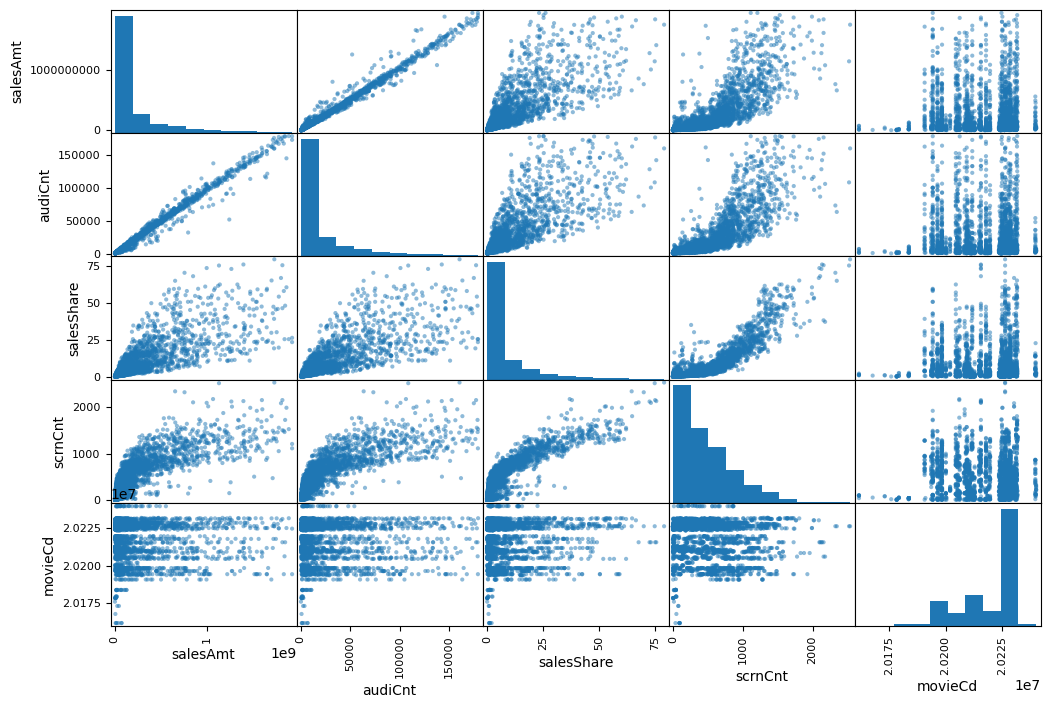

In [42]:
from pandas.plotting import scatter_matrix

attributes = ['salesAmt', 'audiCnt', 'salesShare', 'scrnCnt', 'movieCd']
scatter_matrix(final_df[attributes], figsize=(12,8))
plt.show()

In [43]:
final_df["ticketRatio"] = final_df["audiCnt"]/final_df["showCnt"]
final_df

,date,movieCd,movieNm,salesAmt,salesShare,scrnCnt,showCnt,audiCnt,genres,ticketRatio
0,20220530,20212855,닥터 스트레인지: 대혼돈의 멀티버스,203802130,8.4,695,2461,18972,"어드벤처, 판타지, 액션",7.709061
1,20220530,20224634,그대가 조국,145421230,6.0,457,1075,14894,다큐멘터리,13.854884
2,20220530,20224304,피는 물보다 진하다,7424400,0.3,71,117,1200,액션,10.256410
3,20220530,20217334,안녕하세요,7737900,0.3,208,289,998,드라마,3.453287
4,20220530,20211568,"아치의 노래, 정태춘",8311000,0.3,63,84,903,다큐멘터리,10.750000
...,...,...,...,...,...,...,...,...,...,...
3425,20230528,20227890,슈퍼 마리오 브라더스,387433258,5.2,631,947,38791,"어드벤처, 애니메이션, 코미디",40.961985
3426,20230528,20231348,극장판 짱구는 못말려: 동물소환 닌자 배꼽수비대,212082259,2.8,445,628,20933,애니메이션,33.332803
3427,20230528,20231677,남은 인생 10년,145137100,1.9,201,375,13032,멜로/로맨스,34.752000
3428,20230528,20226270,스즈메의 문단속,128179167,1.7,315,394,12764,애니메이션,32.395939


In [44]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
movie_cat_1hot = cat_encoder.fit_transform(final_df[["genres"]])
movie_cat_1hot.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
strat_train_set = final_df.loc[train_index]
strat_test_set = final_df.loc[test_index]
strat_train_set.to_csv('train.csv', index=False)
strat_test_set.to_csv('test.csv', index=False)

In [58]:
s3_client = boto3.client('s3')
s3_client.upload_file('train.csv', bucket_name, 'AutoML/train.csv')
s3_client.upload_file('test.csv', bucket_name, 'AutoML/test.csv')

In [84]:
final_df

,date,movieCd,movieNm,salesAmt,salesShare,scrnCnt,showCnt,audiCnt,genres,ticketRatio
0,20220530,20212855,닥터 스트레인지: 대혼돈의 멀티버스,203802130,8.4,695,2461,18972,"어드벤처, 판타지, 액션",7.709061
1,20220530,20224634,그대가 조국,145421230,6.0,457,1075,14894,다큐멘터리,13.854884
2,20220530,20224304,피는 물보다 진하다,7424400,0.3,71,117,1200,액션,10.256410
3,20220530,20217334,안녕하세요,7737900,0.3,208,289,998,드라마,3.453287
4,20220530,20211568,"아치의 노래, 정태춘",8311000,0.3,63,84,903,다큐멘터리,10.750000
...,...,...,...,...,...,...,...,...,...,...
3425,20230528,20227890,슈퍼 마리오 브라더스,387433258,5.2,631,947,38791,"어드벤처, 애니메이션, 코미디",40.961985
3426,20230528,20231348,극장판 짱구는 못말려: 동물소환 닌자 배꼽수비대,212082259,2.8,445,628,20933,애니메이션,33.332803
3427,20230528,20231677,남은 인생 10년,145137100,1.9,201,375,13032,멜로/로맨스,34.752000
3428,20230528,20226270,스즈메의 문단속,128179167,1.7,315,394,12764,애니메이션,32.395939


In [85]:
movie_summary = summary[["movieCd", "openDt"]]

In [86]:
movie_summary['openDt'] = pd.to_datetime(summary['openDt'], format='%Y%m%d')

/tmp/ipykernel_11879/1806179904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_summary['openDt'] = pd.to_datetime(summary['openDt'], format='%Y%m%d')


In [88]:
training_df = final_df[["date", "movieCd", "salesAmt", "genres", "ticketRatio"]]
training_df["date"] = pd.to_datetime(training_df['date'], format='%Y%m%d')

training_df

/tmp/ipykernel_11879/2087750297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df["date"] = pd.to_datetime(training_df['date'], format='%Y%m%d')


,date,movieCd,salesAmt,genres,ticketRatio
0,2022-05-30,20212855,203802130,"어드벤처, 판타지, 액션",7.709061
1,2022-05-30,20224634,145421230,다큐멘터리,13.854884
2,2022-05-30,20224304,7424400,액션,10.256410
3,2022-05-30,20217334,7737900,드라마,3.453287
4,2022-05-30,20211568,8311000,다큐멘터리,10.750000
...,...,...,...,...,...
3425,2023-05-28,20227890,387433258,"어드벤처, 애니메이션, 코미디",40.961985
3426,2023-05-28,20231348,212082259,애니메이션,33.332803
3427,2023-05-28,20231677,145137100,멜로/로맨스,34.752000
3428,2023-05-28,20226270,128179167,애니메이션,32.395939


In [112]:
train_set = pd.merge(training_df, movie_summary.drop_duplicates(), on='movieCd', how='left')
train_set

,date,movieCd,salesAmt,genres,ticketRatio,openDt
0,2022-05-30,20212855,203802130,"어드벤처, 판타지, 액션",7.709061,2022-05-04
1,2022-05-30,20224634,145421230,다큐멘터리,13.854884,2022-05-25
2,2022-05-30,20224304,7424400,액션,10.256410,2022-05-25
3,2022-05-30,20217334,7737900,드라마,3.453287,2022-05-25
4,2022-05-30,20211568,8311000,다큐멘터리,10.750000,2022-05-18
...,...,...,...,...,...,...
3425,2023-05-28,20227890,387433258,"어드벤처, 애니메이션, 코미디",40.961985,2023-04-26
3426,2023-05-28,20231348,212082259,애니메이션,33.332803,NaT
3427,2023-05-28,20231677,145137100,멜로/로맨스,34.752000,2023-05-24
3428,2023-05-28,20226270,128179167,애니메이션,32.395939,NaT


In [114]:
train_set["showingDays"] = train_set["date"] - train_set["openDt"]
train_set["showingDays"] = train_set["showingDays"].dt.days
train_set = train_set.dropna()
train_set

/tmp/ipykernel_11879/476896924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["showingDays"] = train_set["date"] - train_set["openDt"]
/tmp/ipykernel_11879/476896924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["showingDays"] = train_set["showingDays"].dt.days


,date,movieCd,salesAmt,genres,ticketRatio,openDt,showingDays
0,2022-05-30,20212855,203802130,"어드벤처, 판타지, 액션",7.709061,2022-05-04,26
1,2022-05-30,20224634,145421230,다큐멘터리,13.854884,2022-05-25,5
2,2022-05-30,20224304,7424400,액션,10.256410,2022-05-25,5
3,2022-05-30,20217334,7737900,드라마,3.453287,2022-05-25,5
4,2022-05-30,20211568,8311000,다큐멘터리,10.750000,2022-05-18,12
...,...,...,...,...,...,...,...
3423,2023-05-28,20231496,1407584810,액션,38.115971,2023-05-03,25
3424,2023-05-28,20231839,1255144962,Other,27.876818,2023-05-24,4
3425,2023-05-28,20227890,387433258,"어드벤처, 애니메이션, 코미디",40.961985,2023-04-26,32
3427,2023-05-28,20231677,145137100,멜로/로맨스,34.752000,2023-05-24,4


In [115]:
train_set.to_csv('train_set.csv', index=False)
s3_client.upload_file('train_set.csv', bucket_name, 'AutoML/train_set.csv')